# Reduced equations (steady-state solution)

Let's find the steady-state solution for the reduced equations:

$$ 0 = \frac{\partial \mathcal{W}}{\partial t} = \frac{1}{\Sigma \Omega R^3 } \frac{\partial \mathcal{G}}{\partial R} - \left(\frac{\Omega_z^2 - \Omega^2}{\Omega^2} \right) \frac{i\Omega}2 \mathcal{W}.$$
$$ 0 = \frac{\partial \mathcal{G}}{\partial t} = \frac{\Sigma H^2 \Omega^3 R^3}4 \frac{\partial \mathcal{W}}{\partial R}  - \left( \frac{\kappa^2 - \Omega^2}{\Omega^2} \right) \frac{i\Omega}2 \mathcal{G} - \alpha \Omega \mathcal{G}, $$

I'll follow `reduced-eqs-zhu2019.ipynb` and assume there's only one planet in the system.

# Imports and normalizations

In [2]:
# %pip install fipy

# make 3D plots interactive
use_interactive_plots = False
if use_interactive_plots:
    %matplotlib notebook

import numpy as np
import pandas as pd
import tables
import time
import math
#import scipy.differentiate
import scipy.integrate as integ
import scipy.interpolate as interp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Zhu 2019 uses these parameters: $h\sim H=0.1$, $\alpha=10^{-3},10^{-2},10^{-1}$, planet at $a=1$, $M_p/M_\star=0.003,0.01$.

For the reduced equations to be valid, we require $\alpha \lesssim c_s \sim h$.

In [3]:
cs = 0.02 # 0.02
alpha = 0.01 # 0.1 # 0.019

# Numerical derivatives

In [4]:
def derivative(f, x):
    '''
    Returns first derivative of f(x) with respect to the domain x.

    '''
    
    # return scipy.differentiate.derivative(f, x)

    derivs = np.zeros(shape=f.shape)

    # handle boundaries
    derivs[0] = (f[1] - f[0]) / (x[1] - x[0])
    derivs[-1] = (f[-1] - f[-2]) / (x[-1] - x[-2])

    # central difference method
    for i in range(1, len(x)-1):
        derivs[i] = (f[i+1] - f[i-1]) / (x[i+1] - x[i-1])

    return derivs

# Disk information

Normalizations:
- $R_0 = 1$
- $\Omega_{K,0} = 1$ (so $GM = 1$)
- $\Sigma_0 = 1$
- $c_s = 0.02$ (which implies $H = c_s/\Omega \sim 0.02$)
- $\alpha = 0.019$
- Density profile: $K, R_a, R_b, D_a, D_b = 19, 1, 2, 0.1, 0.2$

## Density profile

In [5]:
def Sigma(Rs, use_gap):
    '''
    Returns the disk's background surface density profile.
    If use_gap is False, do not include a gap in the profile.
    
    '''
    
    K, R_a, R_b, D_a, D_b = 19, 1, 2, 0.1, 0.2
    fgaps = f_gap(Rs, K, R_a, R_b, D_a, D_b, use_gap)
    
    Sigma0 = 1
    
    return Sigma0 * Rs**(-3/2) / fgaps

def f_gap(Rs, K, R_a, R_b, D_a, D_b, use_gap):
    '''
    Function that "shapes" the disk gap profile. Used in `sigma` function. 
    R_a and R_b are the locations of the inner and outer gap edges,
    D_a and D_b are the steepness of the edges, and K determines the
    depth of the gap.
    If use_gap is False, return 1 (i.e., no disk gap).
    
    '''

    if use_gap:
        return 1 + (K-1)/2 * \
            (np.tanh((Rs - R_a)/D_a) - np.tanh((Rs - R_b)/D_b))
    else:
        return 1

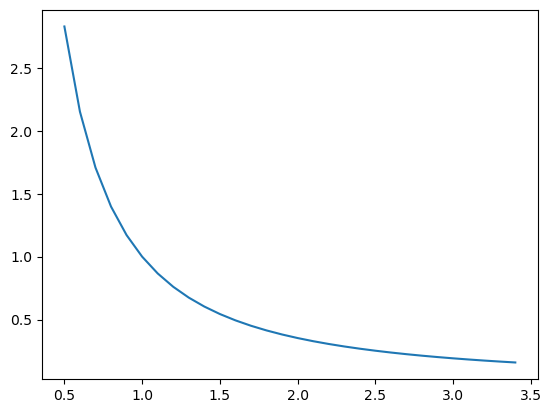

In [6]:
## check shape of disk profile
Rs_warp = np.arange(0.5, 3.5, 0.1)
K, R_a, R_b, D_a, D_b = 19, 1, 2, 0.1, 0.2
plt.plot(Rs_warp, Sigma(Rs_warp, False))

## Keplerian orbital frequency

Scale height, which depends on $\Omega$, is defined in the "Planet information" section below.

In [7]:
def OmegaK(Rs):
    '''
    Returns the Keplerian orbital frequency profile.
    Omega_K = sqrt(G*M_star / R^3)

    '''
    OmegaK_0 = 1 # Omega_K at R=R_0
    return OmegaK_0 * Rs**(-3/2)

# Planet information

If we insert one planet at the disk's inner boundary and one at the disk's outer boundary, can we reproduce Jiaru's results from using fixed (i.e., Dirichlet) boundary conditions?

In [8]:
# planet parameters
Mp, a = 0.003, 1
# toggle disk gap
use_gap = False

### `dG_dt, dW_dt`

In [9]:
def dG_dt(Rs_torque, Gs, Rs_warp, Ws, Mp, a, use_gap):
    '''
    Returns dG/dt over the R domain (Rs_torque) for Gs.
    
    Assumes that `Ws` and `Gs` are staggered in the R domain:
    Ws should be indexed from 0 through N, while `Gs` should be indexed
    from -1/2 to N+1/2.
    
    Mp and a are the planet's mass and orbital radius respectively.

    `use_gap` toggles if the disk's background profile has a gap.
    
    '''
    
    # validate parameters
    if (len(Rs_torque) != len(Gs)):
        raise ValueError("Rs_torque and Gs must have same length")
    if (len(Rs_warp) != len(Ws)):
        raise ValueError("Rs_warp and Ws must have same length")
    if (len(Rs_torque) != (len(Rs_warp) + 1)):
        raise ValueError("Length of Rs_torque should be (length of Rs_warp)+1")
    if (Gs[0] != 0 or Gs[-1] != 0):
        raise ValueError("First and last entries in Gs should be 0")

    # since we're changing G, compute values over G's R domain
    Sigmas = Sigma(Rs_torque, use_gap) # length N+2
    Hs = scaleHeight(Rs_torque)
    Omegas = Omega(Rs_torque, Mp, a)
    
    dW_dRs_mid = (Ws[1:] - Ws[:-1]) / (Rs_warp[1:] - Rs_warp[:-1]) # length N
    dW_dRs = np.zeros(shape=Rs_torque.shape, dtype=complex)
    dW_dRs[1:-1] = dW_dRs_mid

    # sloshing term
    slosh_term = Sigmas * (Hs**2) * (Omegas**3) * (Rs_torque**3) / 4 * dW_dRs
    # external torque term
    Kappas = Kappa(Rs_torque, Mp, a)
    ext_term = (-1) * (Kappas**2 - Omegas**2) / (Omegas**2) * (1j*Omegas/2) * Gs
    # viscous term
    visc_term = (-1) * alpha * Omegas * Gs 
    
    dG_dts = slosh_term + ext_term + visc_term
    
    return dG_dts

def dW_dt(Rs_torque, Gs, Rs_warp, Ws, Mp, a,\
          use_gap, inner_BC, outer_BC):
    '''
    Returns dW/dt over the R domain (Rs) for Ws.
    
    Assumes that `Ws` and `Gs` are staggered in the R domain:
    Ws should be indexed from 0 through N, while `Gs` should be indexed
    from -1/2 to N+1/2.
    
    Mp and a are the planet's mass and orbital radius respectively.

    `use_gap` toggles if the disk's background profile has a gap.
    
    `inner_BC` and `outer_BC` determine the boundary conditions (BCs). The possible
    values are:
    1. "None": No BC.
    2. "Dirichlet": W=constant.
    3. "Neumann": dW_dR=0.

    '''

    # validate parameters
    if (len(Rs_torque) != len(Gs)):
        raise ValueError("Rs_torque and Gs must have same length")
    if (len(Rs_warp) != len(Ws)):
        raise ValueError("Rs_warp and Ws must have same length")
    if (len(Rs_torque) != (len(Rs_warp) + 1)):
        raise ValueError("Length of Rs_torque should be (length of Rs_warp)+1") 
    if (Gs[0] != 0 or Gs[-1] != 0):
        raise ValueError("First and last entries in Gs should be 0")
        
    # since we're changing W, compute values over W's R domain
    Sigmas = Sigma(Rs_warp, use_gap) # length N+1
    Omegas = Omega(Rs_warp, Mp, a)
    
    # defines dG_dR for the W indices 0 through N
    dG_dRs = (Gs[1:] - Gs[:-1]) / (Rs_torque[1:] - Rs_torque[:-1]) # length N+1
    
    # internal torquing term
    int_term = dG_dRs / (Sigmas * Omegas * Rs_warp**3)
    # external torque term
    Omega_zs = Omega_z(Rs_warp, Mp, a)
    ext_term = (-1) * (Omega_zs**2 - Omegas**2) / (Omegas**2) * (1j*Omegas/2) * Ws

    dW_dts = int_term + ext_term
    
    # enforce boundary conditions
    if inner_BC=="Dirichlet":
        dW_dts[0] = 0 
    elif inner_BC=="Neumann": # set W[0] equal to W[1]
        dW_dts[0] = (dW_dts[1] + Ws[1]) - Ws[0]
    elif inner_BC != "None":
        raise ValueError("inner_BC must be \"Dirichlet\", \"Neumann\", or \"None\"")
    
    if outer_BC=="Dirichlet":
        dW_dts[-1] = 0 
    elif outer_BC=="Neumann": # set W[-1] equal to W[-2]
        dW_dts[-1] = (dW_dts[-2] + Ws[-2]) - Ws[-1]
    elif outer_BC != "None":
        raise ValueError("outer_BC must be \"Dirichlet\", \"Neumann\", or \"None\"")
    
    return dW_dts

## Laplace coefficients

In [10]:
# softening term in disk potential; reflects the disk's scale height
soft_term = 0.1

def laplace_coeff_integrand(phi, x, j, s):
    '''
    
    This function represents the integrand of the Laplace coefficient formula
    (Eq. 6.67 of Murray & Dermott). The result is used in the laplace_coeff function.
    
    PARAMETERS
    ----------
    phi: the variable that we integrate over
    x: the variable that isn't integrated over
    j, s: See Eq. 6.67 of Murray & Dermott or Eq. 21 in Lubow+Ogilvie.
    
    '''
    
    num = np.cos(j*phi) # numerator
    denom = (1 - 2 * x * np.cos(phi) + x**2 + soft_term**2) ** s
    
    return num / denom

def laplace_coeff(x, j, s):
    '''
    
    Calculate the Laplace coefficient using Eq. 6.67 of Murray & Dermott.

    
    PARAMETERS
    ----------
    x: argument of the Laplace coefficient formula
    
    '''
    
    return 2 / np.pi * integ.quad(laplace_coeff_integrand, 0, np.pi, args=(x, j, s))[0]

Depending on whether the planet is inside ($R \gg a$; large $\alpha$) or outside ($R \ll a$; small $\alpha$) the disk, we can use the quadrupole approximations the Laplace coefficients:

In [11]:
def b0_approx(alpha, limit):
    '''
    Approximates the Laplace coefficient b^0_{3/2} as a function of 
    alpha = R/a.
    
    If alpha << 1, set `limit` to "small". If alpha >> 1, set 
    `limit` to "large".
    
    '''
    
    if limit=="small":
        return 2 
    elif limit=="large":
        return 2/alpha**3
    else:
        raise ValueError("limit must be either \"small\" or \"large.\"")

def b1_approx(alpha, limit):
    '''
    Approximates the Laplace coefficient b^1_{3/2} as a function of 
    alpha = R/a.
    
    '''
    
    if limit=="small":
        return 3*alpha 
    elif limit=="large":
        return 3/alpha**4 
    else:
        raise ValueError("limit must be either \"small\" or \"large.\"")

But if $\alpha \sim 1$, we should interpolate the Laplace coefficients:

In [12]:
# interpolate Laplace coefficient function (~10x faster)
# large alpha limit
xs_temp = np.linspace(1.001, 20, 10000)
ys_temp = [laplace_coeff(x, j=0, s=3/2) for x in xs_temp]
b0_interp_large_alpha = interp.CubicSpline(xs_temp, ys_temp)

ys_temp = [laplace_coeff(x, j=1, s=3/2) for x in xs_temp]
b1_interp_large_alpha = interp.CubicSpline(xs_temp, ys_temp)

# small alpha limit
xs_temp = np.linspace(1e-3, .999, 1000)
ys_temp = [laplace_coeff(x, j=0, s=3/2) for x in xs_temp]
b0_interp_small_alpha = interp.CubicSpline(xs_temp, ys_temp)

ys_temp = [laplace_coeff(x, j=1, s=3/2) for x in xs_temp]
b1_interp_small_alpha = interp.CubicSpline(xs_temp, ys_temp)

And let's check that our approximated functions are accurate:

In [13]:
# correctness checks
print("Correctness check: for alpha >> 1, b^1_{3/2} ~ 3/alpha^4.")
x = 1.03
print(laplace_coeff(x, j=1, s=3/2))
print(b1_approx(x,limit="large"))
print(b1_interp_large_alpha(x))

print("\nCorrectness check: for alpha >> 1, b^0_{3/2} ~ 2/alpha^3.")
x = 12
print(laplace_coeff(x, j=0, s=3/2))
print(b0_approx(x,limit="large"))
print(b0_interp_large_alpha(x))

print("\nCorrectness check: for alpha << 1, b^1_{3/2} ~ 3*alpha.")
x = .9999
print(laplace_coeff(x, j=1, s=3/2))
print(b1_approx(x,limit="small"))
print(b1_interp_small_alpha(x))

print("\nCorrectness check: for alpha << 1, b^0_{3/2} ~ 2.")
x = .999
print(laplace_coeff(x, j=0, s=3/2))
print(b0_approx(x,limit="small"))
print(b0_interp_small_alpha(x))


Correctness check: for alpha >> 1, b^1_{3/2} ~ 3/alpha^4.
56.745809328645954
2.6654611437470663
56.745809324541796

Correctness check: for alpha >> 1, b^0_{3/2} ~ 2/alpha^3.
0.0011755641009470485
0.0011574074074074073
0.0011755641009470476

Correctness check: for alpha << 1, b^1_{3/2} ~ 3*alpha.
62.81894742199641
2.9997
62.8189378474609

Correctness check: for alpha << 1, b^0_{3/2} ~ 2.
63.91644481121259
2
63.9164448112126


## Orbital, epicyclic, and radial frequencies

(I use Eqs. 25-27 in Lubow+Ogilvie 2000.)

In [14]:
def Omega(R, Mp, a):
    '''
    Returns the disk's orbital frequency at R. 
    
    VARIABLES:
    ----------
    R is the radial coordinate.
    Mp is the ratio of the planet's mass to the star mass (using the normalization 
    GM_star = 1). For example, if we assume M_star = 1 M_sun, then a Jupiter-mass
    planet would have Mp = 0.001.
    a is the radius of the planet's orbit.

    '''

    Omega_sq = OmegaK(R)**2
    alpha = R/a

    if alpha==1:
        raise ValueError("Can't have `a` in the list of Rs; otherwise, we have R/a = 1")

    planet_term = 0
    
    if alpha < 1:
        planet_term = Mp/(2 * a**2 * R) * (alpha*b0_interp_small_alpha(alpha) - \
                        b1_interp_small_alpha(alpha))
    elif alpha > 1:
        planet_term = Mp/(2 * a**2 * R) * (alpha*b0_interp_large_alpha(alpha) - \
                        b1_interp_large_alpha(alpha))
    Omega_sq += planet_term
    
    return np.sqrt(Omega_sq)

def Kappa(R, Mp, a):
    '''
    Returns the disk's epicyclic frequency at R. 
    
    VARIABLES:
    ----------
    R is the radial coordinate.
    Mp is the ratio of the planet's mass to the star mass (using the normalization 
    GM_star = 1). For example, if we assume M_star = 1 M_sun, then a Jupiter-mass
    planet would have Mp = 0.001.
    a is the radius of the planet's orbit.

    '''

    kappa_sq = OmegaK(R)**2
    alpha = R/a
    
    if alpha==1:
        raise ValueError("Can't have `a` in the list of Rs; otherwise, we have R/a = 1")

    planet_term = 0
    
    if alpha < 1:
        planet_term = Mp/(2 * a**2 * R) * (alpha*b0_interp_small_alpha(alpha) - \
                        2*b1_interp_small_alpha(alpha))
    elif alpha > 1:
        planet_term = Mp/(2 * a**2 * R) * (alpha*b0_interp_large_alpha(alpha) - \
                        2*b1_interp_large_alpha(alpha))
    kappa_sq += planet_term

    return np.sqrt(kappa_sq)

def Omega_z(R, Mp, a):
    '''
    Returns the disk's vertical frequency at R. 
    
    VARIABLES:
    ----------
    R is the radial domain.
    Mp is the ratio of the planet's mass to the star mass (using the normalization 
    GM_star = 1). For example, if we assume M_star = 1 M_sun, then a Jupiter-mass
    planet would have Mp = 0.001.
    a is the radius of the planet's orbit.

    '''

    Omegaz_sq = OmegaK(R)**2
    alpha = R/a
    
    if alpha==1:
        raise ValueError("Can't have `a` in the list of Rs; otherwise, we have R/a = 1")

    planet_term = 0
    
    if alpha < 1:
        planet_term = Mp/(2 * a**2 * R) * alpha*b0_interp_small_alpha(alpha)
    elif alpha > 1:
        planet_term = Mp/(2 * a**2 * R) * alpha*b0_interp_large_alpha(alpha)
    Omegaz_sq += planet_term

    return np.sqrt(Omegaz_sq)

# vectorize functions to avoid errors with the boolean comparisons
Omega = np.vectorize(Omega)
Kappa = np.vectorize(Kappa)
Omega_z = np.vectorize(Omega_z)

## Disk scale height

In [15]:
def scaleHeight(Rs):
    '''
    Returns the disk's scale height profile. We use H = c_sound / Omega_K.

    '''
    return cs / OmegaK(Rs)

In [16]:
# # spatial and time domains
# Rmin = 0.5
# Rmax = 3.5 
# Rmid = 1.5 # arbitrary point in middle of disk gap
    
# DeltaR = 0.1 # 0.03
# num_Rs = (int) ((Rmax - Rmin) / DeltaR) + 1

# Rs_warp = np.linspace(Rmin, Rmax, num_Rs)

# cses = scaleHeight(Rs_warp)
# plt.plot(Rs_warp, 10*cses)

# print("Courant condition: dt < ", DeltaR / max(cses))

# Steady-state solution

## `compute_dGdR` and `compute_dWdR`

In [17]:
def compute_dGdR(R, W, Mp, a, use_gap):
    '''
    Returns dG/dR at a specific coordinate R. W is the value of tilt
    at R.
    
    Mp and a are the planet's mass and orbital radius respectively.

    `use_gap` toggles if the disk's background profile has a gap.
    
    '''

    S = Sigma(R, use_gap) 
    O = Omega(R, Mp, a)
    Oz = Omega_z(R, Mp, a)
    
    coeff1 = S * O**2 * R**3
    coeff2 = (Oz**2 - O**2) / (O**2) * (1j/2)
    
    return coeff1 * coeff2 * W

def compute_dWdR(R, G, Mp, a, use_gap):
    '''
    Returns dW/dR at a specific coordinate R. G is the value of internal
    torque at R.
    
    Mp and a are the planet's mass and orbital radius respectively.

    `use_gap` toggles if the disk's background profile has a gap.
    
    '''

    S = Sigma(R, use_gap)
    H = scaleHeight(R)
    O = Omega(R, Mp, a)
    K = Kappa(R, Mp, a)
    
    coeff1 = 4 / (S * H**2 * O**2 * R**3)
    coeff2 = (K**2 - O**2) / (O**2) * (1j/2) + alpha
    
    return coeff1 * coeff2 * G

## Solve for steady-state

We start from the outer edge and move inwards.

In [40]:
# spatial domain
Rmin = 0.5
Rmax = 3.5
DeltaR = .3 # 0.03
num_Rs = (int) ((Rmax - Rmin) / DeltaR) + 1

# stagger W and G in the R domain
Rs_warp = np.linspace(Rmin, Rmax, num_Rs)
#Rs_warp = np.delete(Rs_warp, np.searchsorted(Rs_warp, a)) # exclude R=1 point
#Rs_torque = np.zeros(shape=((num_Rs))) # exclude R=1 point
Rs_torque = np.zeros(shape=((num_Rs+1)))
Rs_torque[0] = Rs_warp[0] - DeltaR/2
Rs_torque[1:] = Rs_warp.copy() + DeltaR/2

# initialize W and G arrays
Ws = np.zeros(shape=((num_Rs)))
Ws = Ws.astype(complex)
#Ws[-1] = 0.1+0j
Ws[0] = 1e-9
Gs = np.zeros(shape=Rs_torque.shape)
Gs = Gs.astype(complex)
Gs[0] = 0

In [41]:
# step FORWARD through arrays
for i in np.arange(0, num_Rs):
    ## 1. Given G_{i-1/2} and W_i, update G_{i+1/2}
    W_i = Ws[i] # W_i
    dR = Rs_torque[i+1] - Rs_torque[i]
    R_i = Rs_warp[i]

    dGdR = compute_dGdR(R_i, W_i, Mp, a, use_gap)
    Gs[i+1] = Gs[i] + dGdR*dR
    

    ## 2. Given W_i and G_{i+1/2}, update W_{i+1}
    if (i == (num_Rs-1)): break # outer edge
    G_ihalf = Gs[i+1]
    dR = Rs_warp[i+1] - Rs_warp[1]
    R_ihalf = Rs_torque[i+1]

    dWdR = compute_dWdR(R_ihalf, G_ihalf, Mp, a, use_gap)
    Ws[i+1] = Ws[i] + dWdR*dR


In [20]:
# # step back through arrays
# for i in np.arange(num_Rs, 0, -1):
#     ## 1. Given G_{i+1/2} and W_i, update G_{i-1/2}
#     if (i != num_Rs): # use if Gs[-2] already initialized
#         W_i = Ws[i-1] # W_i
#         dR = Rs_torque[i] - Rs_torque[i-1]
#         R_i = Rs_warp[i-1]
    
#         dGdR = compute_dGdR(R_i, W_i, Mp, a, use_gap)
#         Gs[i-1] = Gs[i] - dGdR*dR

#     ## 2. Given W_i and G_{i-1/2}, update W_{i-1}
#     if (i == 1): break # inner edge
#     G_ihalf = Gs[i-1]
#     dR = Rs_warp[i-1] - Rs_warp[i-2]
#     R_ihalf = Rs_torque[i-1]

#     dWdR = compute_dWdR(R_ihalf, G_ihalf, Mp, a, use_gap)
#     Ws[i-2] = Ws[i-1] - dWdR*dR

In [30]:
# load in time-dependent data
file_path = "Data/W_tseries/zhu-inspired/Dirich-outerBC/alpha=" + str(alpha) + \
    ",h=" + str(cs) + ",Mp=" + str(Mp) + ",eps=" +str(soft_term) +".h5"
W_tseries0 = pd.read_hdf(file_path, key='W_tseries', mode='r')
Ws_final0 = W_tseries0.iloc[-1]

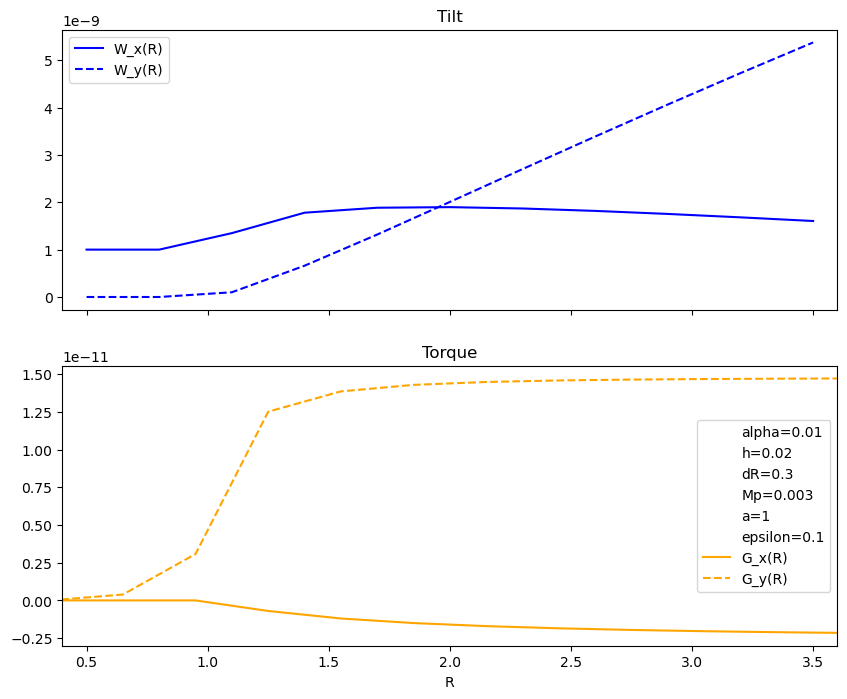

In [42]:
fig, axs = plt.subplots(2, sharex=True, figsize=(10,8))
fig.set_facecolor("white")

#fudge = .2 # fudge factor
# axs[0].plot(Ws_final0.index, Ws_final0.values.real, c="orange", label="time-dep W_x")
# axs[0].plot(Ws_final0.index, Ws_final0.values.imag, c="orange", ls='--',\
#             label="time-dep W_y")
axs[0].plot(Rs_warp, Ws.real, c="blue", label="W_x(R)")
axs[0].plot(Rs_warp, Ws.imag, c="blue", ls='--', label="W_y(R)")

# ymin, ymax= min(Ws.real)- .01, max(Ws.real) + .01
if use_gap:
    R_a, R_b = 1, 2
    axs[0].vlines(R_a, ymin, ymax, color="black", linestyle=":")
    axs[0].vlines(R_b, ymin, ymax, color="black", linestyle=":", label="Gap edges")

#axs[0].set_ylim(ymin,ymax)

axs[1].scatter([],[], s=0, label="alpha=" + str(alpha))
axs[1].scatter([],[], s=0, label="h=" + str(cs))
#axs[1].scatter([],[], s=0, label="BCs: G=0")
axs[1].scatter([],[], s=0, label="dR="+str(DeltaR))
axs[1].scatter([],[], s=0, label="Mp=" + str(Mp))
axs[1].scatter([],[], s=0, label="a=" + str(a))
axs[1].scatter([],[], s=0, label="epsilon=" + str(soft_term))

axs[0].legend()
axs[0].set_title("Tilt")

axs[1].plot(Rs_torque, Gs.real, c="orange", label="G_x(R)")
axs[1].plot(Rs_torque, Gs.imag, c="orange", ls='--', label="G_y(R)")

#ymin, ymax= min(Ws.imag) - .01, max(Ws.imag) + .01
if use_gap:
    R_a, R_b = 1, 2
    axs[1].vlines(R_a, ymin, ymax, color="black", linestyle=":")
    axs[1].vlines(R_b, ymin, ymax, color="black", linestyle=":")#, label="Gap edges")

axs[1].set_xlim(Rmin - 0.1, Rmax + 0.1)
#axs[1].set_ylim(ymin,ymax)

axs[1].legend()
axs[1].set_title("Torque")

axs[1].set_xlabel("R")

save_figs = True

if save_figs:
    filepath = "Figures/steady-state/WG.png"
    plt.savefig(filepath)

plt.show()

## Sanity check: plot dW_dR and dG_dR

Text(0.5, 1.0, 'Delta W')

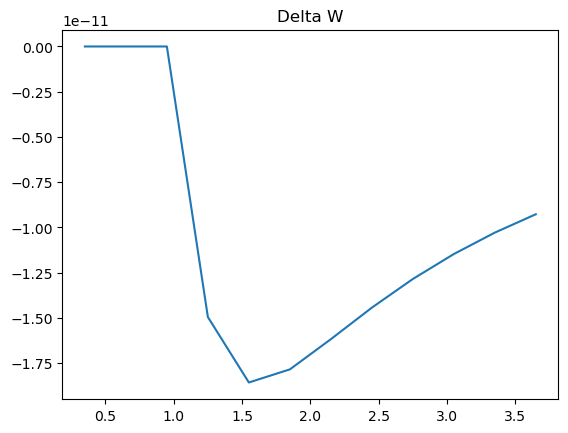

In [44]:
dWdRs = compute_dWdR(Rs_torque, Gs.real, Mp, a, use_gap)
plt.plot(Rs_torque, DeltaR*dWdRs)

plt.title("Delta W")

## Reached steady-state?

Let's verify that we've reached steady-state.

### `dG_dt` and `dW_dt`

In [86]:
def dG_dt(Rs_torque, Gs, Rs_warp, Ws, Mp, a, use_gap):
    '''
    Returns dG/dt over the R domain (Rs_torque) for Gs.
    
    Assumes that `Ws` and `Gs` are staggered in the R domain:
    Ws should be indexed from 0 through N, while `Gs` should be indexed
    from -1/2 to N+1/2.
    
    Mp and a are the planet's mass and orbital radius respectively.

    `use_gap` toggles if the disk's background profile has a gap.
    
    '''
    
    # validate parameters
    if (len(Rs_torque) != len(Gs)):
        raise ValueError("Rs_torque and Gs must have same length")
    if (len(Rs_warp) != len(Ws)):
        raise ValueError("Rs_warp and Ws must have same length")
    if (len(Rs_torque) != (len(Rs_warp) + 1)):
        raise ValueError("Length of Rs_torque should be (length of Rs_warp)+1")
    #if (Gs[0] != 0 or Gs[-1] != 0):
     #   raise ValueError("First and last entries in Gs should be 0")

    # since we're changing G, compute values over G's R domain
    Sigmas = Sigma(Rs_torque, use_gap) # length N+2
    Hs = scaleHeight(Rs_torque)
    Omegas = Omega(Rs_torque, Mp, a)
    
    dW_dRs_mid = (Ws[1:] - Ws[:-1]) / (Rs_warp[1:] - Rs_warp[:-1]) # length N
    dW_dRs = np.zeros(shape=Rs_torque.shape, dtype=complex)
    dW_dRs[1:-1] = dW_dRs_mid

    # sloshing term
    slosh_term = Sigmas * (Hs**2) * (Omegas**3) * (Rs_torque**3) / 4 * dW_dRs
    # external torque term
    Kappas = Kappa(Rs_torque, Mp, a)
    ext_term = (-1) * (Kappas**2 - Omegas**2) / (Omegas**2) * (1j*Omegas/2) * Gs
    # viscous term
    visc_term = (-1) * alpha * Omegas * Gs 
    
    dG_dts = slosh_term + ext_term + visc_term
    
    return dG_dts

def dW_dt(Rs_torque, Gs, Rs_warp, Ws, Mp, a,\
          use_gap, inner_BC, outer_BC):
    '''
    Returns dW/dt over the R domain (Rs) for Ws.
    
    Assumes that `Ws` and `Gs` are staggered in the R domain:
    Ws should be indexed from 0 through N, while `Gs` should be indexed
    from -1/2 to N+1/2.
    
    Mp and a are the planet's mass and orbital radius respectively.

    `use_gap` toggles if the disk's background profile has a gap.
    
    `inner_BC` and `outer_BC` determine the boundary conditions (BCs). The possible
    values are:
    1. "None": No BC.
    2. "Dirichlet": W=constant.
    3. "Neumann": dW_dR=0.

    '''

    # validate parameters
    if (len(Rs_torque) != len(Gs)):
        raise ValueError("Rs_torque and Gs must have same length")
    if (len(Rs_warp) != len(Ws)):
        raise ValueError("Rs_warp and Ws must have same length")
    if (len(Rs_torque) != (len(Rs_warp) + 1)):
        raise ValueError("Length of Rs_torque should be (length of Rs_warp)+1") 
    #if (Gs[0] != 0 or Gs[-1] != 0):
     #   raise ValueError("First and last entries in Gs should be 0")
        
    # since we're changing W, compute values over W's R domain
    Sigmas = Sigma(Rs_warp, use_gap) # length N+1
    Omegas = Omega(Rs_warp, Mp, a)
    
    # defines dG_dR for the W indices 0 through N
    dG_dRs = (Gs[1:] - Gs[:-1]) / (Rs_torque[1:] - Rs_torque[:-1]) # length N+1
    
    # internal torquing term
    int_term = dG_dRs / (Sigmas * Omegas * Rs_warp**3)
    # external torque term
    Omega_zs = Omega_z(Rs_warp, Mp, a)
    ext_term = (-1) * (Omega_zs**2 - Omegas**2) / (Omegas**2) * (1j*Omegas/2) * Ws

    dW_dts = int_term + ext_term
    
    # enforce boundary conditions
    if inner_BC=="Dirichlet":
        dW_dts[0] = 0 
    elif inner_BC=="Neumann": # set W[0] equal to W[1]
        dW_dts[0] = (dW_dts[1] + Ws[1]) - Ws[0]
    elif inner_BC != "None":
        raise ValueError("inner_BC must be \"Dirichlet\", \"Neumann\", or \"None\"")
    
    if outer_BC=="Dirichlet":
        dW_dts[-1] = 0 
    elif outer_BC=="Neumann": # set W[-1] equal to W[-2]
        dW_dts[-1] = (dW_dts[-2] + Ws[-2]) - Ws[-1]
    elif outer_BC != "None":
        raise ValueError("outer_BC must be \"Dirichlet\", \"Neumann\", or \"None\"")
    
    return dW_dts

### visualize time derivatives

In [91]:
#np.mean(dG_dt(Rs_torque, Gs, Rs_warp, Ws, Mp, a, use_gap))
#np.mean(dW_dt(Rs_torque, Gs, Rs_warp, Ws, Mp, a, use_gap, inner_BC="None", outer_BC="Dirichlet"))

np.complex128(-3.900524777963041e-15j)

In [109]:
dGdts

array([ 0.00000000e+00+0.00000000e+00j, -1.19409165e-15-7.45459864e-15j,
        2.52435490e-29+0.00000000e+00j,  7.24701574e-14+9.42192658e-14j,
        2.34400345e-14+1.47162651e-13j,  3.18413451e-15+1.73059996e-13j,
       -7.67049452e-15+1.85882679e-13j, -1.42041898e-14+1.91880185e-13j,
       -1.83789918e-14+1.94101398e-13j, -2.11363344e-14+1.94149675e-13j,
       -2.29884774e-14+1.92918974e-13j,  2.69306925e-15-2.12145285e-14j])

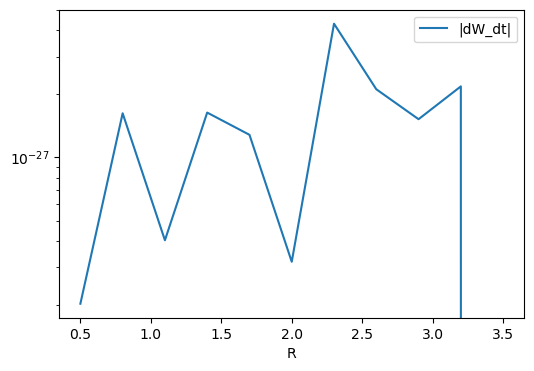

In [107]:
fig = plt.figure(figsize=(6,4))
fig.set_facecolor("white")

dWdts = dW_dt(Rs_torque, Gs, Rs_warp, Ws, Mp, a, use_gap, \
       inner_BC="None", outer_BC="Dirichlet")
plt.plot(Rs_warp, np.abs(dWdts),label="|dW_dt|")

dGdts = dG_dt(Rs_torque, Gs, Rs_warp, Ws, Mp, a, use_gap)
#lt.plot(Rs_torque, np.abs(dGdts),label="|dG_dt|")

# dWdts_final = dW_dt(Rs_torque, Gs_final, Rs_warp, Ws_final, Mp, a, use_gap, \
#        inner_BC, outer_BC)

# plt.plot(Rs_warp, np.abs(dWdts_final), label="final")


plt.xlabel("R")
plt.yscale("log")
#plt.title("|dW/dt|")

plt.legend()
# if save_figs: 
#     filepath = "Figures/dWdt_dGdt.png"
#     plt.savefig(filepath)
plt.show()